<a href="https://colab.research.google.com/github/titika2013/Made_adv_DL/blob/main/homework_1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
import seaborn as sns
import gym # version == 0.25.2

import matplotlib.pyplot as plt
from tqdm import tqdm

## Часть первая, с блекджеком и стратегиями


**1** Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 

In [ ]:
env = gym.make('Blackjack-v1', natural=True)  

In [ ]:
def control_simple(states, treshhold):
    if (treshhold > states[0]):
        return 1  # hit
    else:
        return 0  # stand


def simple_model(treshhold, n_model=100000):
    sum_rew = 0
    for i in range(0, n_model):
        obs = env.reset()
        done = 0
        while not done:
            new_state, reward, done, _ = env.step(control_simple(obs, treshhold))
            obs = new_state
        sum_rew += reward
    return sum_rew / n_model

In [ ]:
res_simple = simple_model(19, 200000)

In [ ]:
print(f'Средний выигрыш при простой стратегии {np.mean(res_simple)}')

Средний выигрыш при простой стратегии -0.19671


**2.** Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

In [ ]:
class Agent:
    def __init__(self, alpha, max_epsilon, gamma, env):

        self.env = env

        self.alpha = alpha
        self.epsilon = max_epsilon
        self.gamma = gamma
        self.valid_actions = env.action_space.n
        self.Q = {}

    def choose_Q(self, observation):
        if observation not in self.Q:
            self.Q[observation] = np.random.uniform(low=-1, high=1, size=self.valid_actions)
        return self.Q[observation]

    def train(self, num_samples=100000, interval=1000):
        rewards_ = np.zeros((num_samples // interval, 2))
        eps_ = self.epsilon
        for samples in tqdm(range(num_samples)):

            self.epsilon = max(self.epsilon * .99999, 0.007)

            if samples % interval == 0:
                total_reward = 0
                for _ in range(num_samples):
                    observation = self.env.reset()
                    is_done = False
                    while not is_done:
                        action = np.argmax(self.choose_Q(observation))
                        observation, reward, is_done, info = self.env.step(action)
                    total_reward += reward
                mean_rew = total_reward / num_samples
                rewards_[samples // interval] = samples, mean_rew

            observation = self.env.reset()
            is_done = False

            while not is_done:
                if np.random.random() > self.epsilon:
                    action = np.argmax(self.choose_Q(observation))
                else:
                    action = random.choice(range(self.valid_actions))
                next_observation, reward, is_done, info = self.env.step(action)
                Q = self.choose_Q(observation)[action]
                if reward == 0:
                    maxQ = np.max(self.choose_Q(next_observation))
                else:
                    maxQ = 0
                self.Q[observation][action] = Q + self.alpha * (reward + self.gamma * maxQ - Q)
                observation = next_observation
        return rewards_


In [ ]:
agent = Agent(alpha=0.01, max_epsilon=0.5, gamma=1, env=gym.make('Blackjack-v1', natural=True))

In [ ]:
res = agent.train(num_samples=100000, interval=1000)

100%|██████████| 100000/100000 [24:31<00:00, 67.98it/s]


**3.** Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

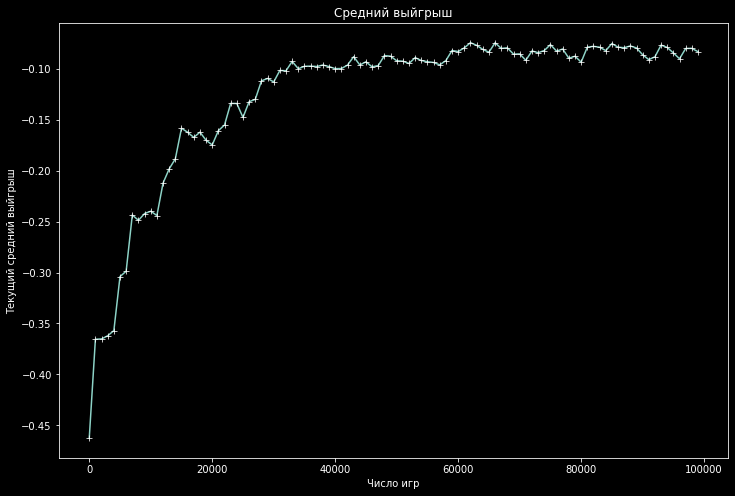

In [ ]:
def plot_res(input_vals):
    fig = plt.figure(figsize=(12, 8))
    plt.title("Средний выйгрыш")
    plt.style.use('dark_background')
    grid = sns.lineplot(x=input_vals[:, 0], y=input_vals[:, 1], marker='+', palette="Accent")
    grid.set(xlabel='Число игр', ylabel='Текущий средний выйгрыш')


plot_res(res)


## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- **double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

**4.** Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.


In [ ]:
#@title  Blackjack with double

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

from typing import Optional


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnvDouble(gym.Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.natural = natural
        self.sab = sab
        self.render_mode = render_mode

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        elif action == 0:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                    not self.sab
                    and self.natural
                    and is_natural(self.player)
                    and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        elif action == 2:
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -2.0
            else:

                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
                terminated = True
        return self._get_obs(), reward, terminated, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(
            self,
            seed: Optional[int] = None,
            options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)

        _, dealer_card_value, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs()

**5.** Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [ ]:
agent2 = Agent(alpha=0.01, max_epsilon=0.5, gamma=1, env=BlackjackEnvDouble())
double_res = agent2.train()

100%|██████████| 100000/100000 [22:22<00:00, 74.51it/s]


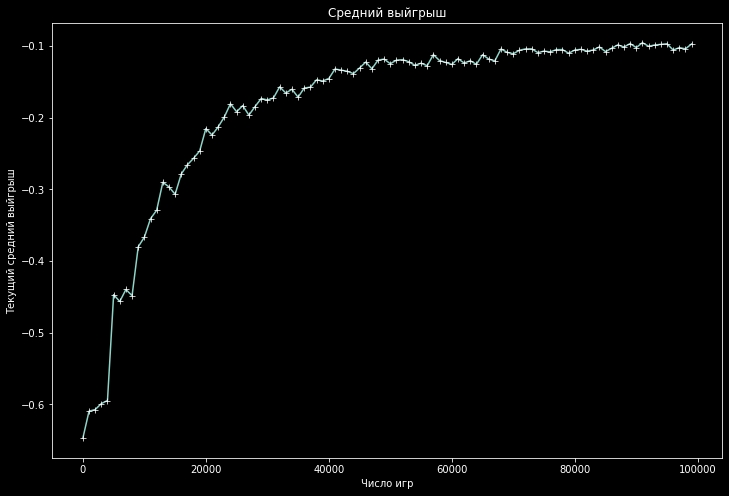

In [ ]:
plot_res(double_res)

## Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

**6.** Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).


In [ ]:
#@title  Blackjack with double and count
import gym
from gym import spaces
from gym.error import DependencyNotInstalled

from typing import Optional


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnvDoubleCount(gym.Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.natural = natural
        self.sab = sab
        self.render_mode = render_mode

        self.deck = deck * 4
        self.count_cards = 0
        self.card_ef = [-1, 0.5, 1, 1, 1.5, 1, 0.5, 0, -0.5, -1]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        elif action == 0:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                    not self.sab
                    and self.natural
                    and is_natural(self.player)
                    and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        elif action == 2:
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -2.0
            else:

                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
                terminated = True
        return self._get_obs(), reward, terminated, {}

    def reset_deck(self):
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        random.shuffle(self.deck)
        self.count_cards = 0

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def draw_card(self, shown_=True):
        card = self.np_random.choice(self.deck)
        self.deck.remove(card)
        self.count_cards += self.card_ef[card - 1]
        return card

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.count_cards)

    def reset(
            self,
            seed: Optional[int] = None,
            options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        if len(self.deck) < 15:
            self.reset_deck()
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()


**7.** Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [ ]:
env = BlackjackEnvDoubleCount(natural=True)
agent3 = Agent(alpha=0.001, max_epsilon=0.5, gamma=1, env=env)

In [ ]:
res_count = agent3.train(num_samples=100000, interval=1000)

100%|██████████| 100000/100000 [23:21<00:00, 71.34it/s]


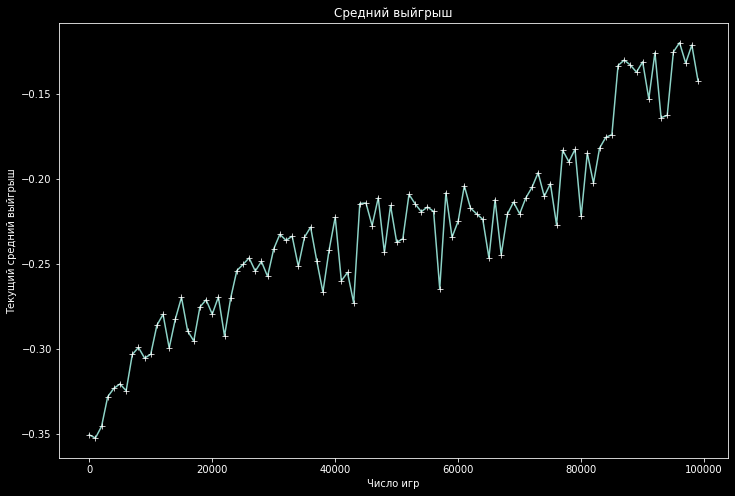

In [ ]:
plot_res(res_count)

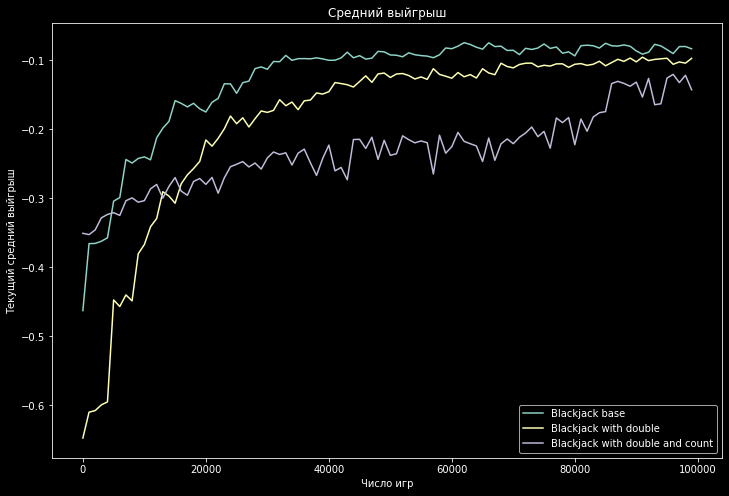

In [ ]:
def plot_res(simple_model, double_model, count_model):
    fig = plt.figure(figsize=(12, 8))
    plt.title("Средний выйгрыш")
    plt.style.use('dark_background')
    grid = sns.lineplot(x=simple_model[:, 0], y=simple_model[:, 1], label="Blackjack base", palette="Accent")
    grid = sns.lineplot(x=double_model[:, 0], label="Blackjack with double", y=double_model[:, 1])
    grid = sns.lineplot(x=count_model[:, 0], label="Blackjack with double and count", y=count_model[:, 1])
    grid.set(xlabel='Число игр', ylabel='Текущий средний выйгрыш')


plot_res(res, double_res, res_count)


Обыграть казино не получилось